In [1]:
import tensorflow as tf
print(f"TensorFlow ver: {tf.__version__}")
print(f"GPU able: {tf.config.list_physical_devices('GPU')}")

TensorFlow ver: 2.10.1
GPU able: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os, json, math, random
import numpy as np
import pandas as pd

In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [4]:
X_ai = np.load("train_ai.npy")
X_human = np.load("train_human.npy")
print(X_ai.shape, X_human.shape)

(8161, 100, 768) (8161, 100, 768)


In [5]:
df_val = pd.read_json("validation.jsonl", lines=True)

X_val_list, y_val_list, val_id_list = [], [], []
for row in df_val.itertuples():
    arr = np.array(row.features, dtype=np.float32)   # (N_i,100,768)
    for sub in arr:  # sub is slice for each id: (100,768)
        X_val_list.append(sub)
        y_val_list.append(row.label)
        val_id_list.append(row.id)

X_val = np.stack(X_val_list)
y_val = np.array(y_val_list)
val_ids = np.array(val_id_list)

print(X_val.shape, y_val.shape, val_ids.shape, len(np.unique(val_ids)))

(220, 100, 768) (220,) (220,) 20


In [6]:
df_test = pd.read_json("test_features.jsonl", lines=True)

X_test_list, test_id_list = [], []
for row in df_test.itertuples():
    arr = np.array(row.features, dtype=np.float32)
    for sub in arr:
        X_test_list.append(sub)
        test_id_list.append(row.id)

X_test = np.stack(X_test_list)
test_ids = np.array(test_id_list)

print(X_test.shape, test_ids.shape, len(np.unique(test_ids)))

(1686, 100, 768) (1686,) 180


In [7]:
from sklearn.utils import shuffle

y_ai = np.ones(len(X_ai),  dtype=np.int64)
y_human = np.zeros(len(X_human), dtype=np.int64)

X_train = np.concatenate([X_ai, X_human], axis=0)
y_train = np.concatenate([y_ai, y_human], axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=SEED)

print(X_train.shape, y_train.shape)

(16322, 100, 768) (16322,)


In [8]:
def mem_gb(x): 
    return x.nbytes / (1024**3)

In [9]:
# 1. base in
print("Train:", X_train.shape, y_train.shape, f"{mem_gb(X_train):.2f} GB")
print("Val  :", X_val.shape, y_val.shape, "unique ids:", len(np.unique(val_ids)))
print("Test :", X_test.shape, "unique ids:", len(np.unique(test_ids)))
print("Class balance (train):", np.mean(y_train))

Train: (16322, 100, 768) (16322,) 4.67 GB
Val  : (220, 100, 768) (220,) unique ids: 20
Test : (1686, 100, 768) unique ids: 180
Class balance (train): 0.5


In [10]:
# 2. value range check
for name, X in [("Train", X_train), ("Val", X_val), ("Test", X_test)]:
    print(f"\n{name} value stats:")
    print("  min:", float(X.min()), "max:", float(X.max()))
    print("  mean:", float(X.mean()), "std:", float(X.std()))
    print("  NaN count:", np.isnan(X).sum(), "Inf count:", np.isinf(X).sum())


Train value stats:
  min: -4.353366374969482 max: 11.07802963256836
  mean: 0.006441014818847179 std: 0.3131546974182129
  NaN count: 0 Inf count: 0

Val value stats:
  min: -4.176572799682617 max: 10.09249210357666
  mean: 0.006693809758871794 std: 0.3185516893863678
  NaN count: 0 Inf count: 0

Test value stats:
  min: -4.448540687561035 max: 10.3704252243042
  mean: 0.0075982618145644665 std: 0.3351835608482361
  NaN count: 0 Inf count: 0


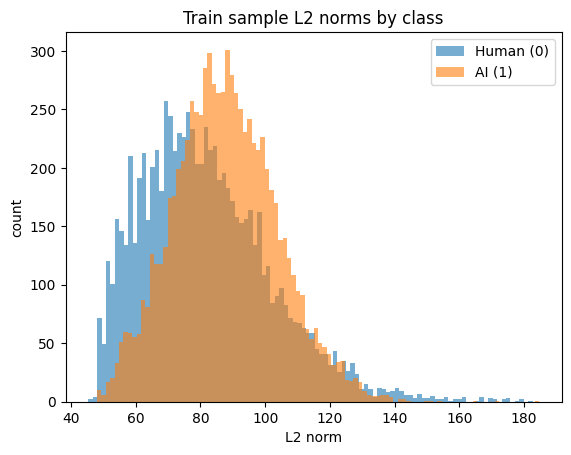

In [11]:
import matplotlib.pyplot as plt

# 3. check train data norm distribution
train_norms = np.linalg.norm(X_train.reshape(len(X_train), -1), axis=1)
ai_norms = train_norms[y_train == 1]
human_norms = train_norms[y_train == 0]
plt.hist(human_norms, bins=100, alpha=0.6, label="Human (0)")
plt.hist(ai_norms, bins=100, alpha=0.6, label="AI (1)")
plt.title("Train sample L2 norms by class")
plt.xlabel("L2 norm")
plt.ylabel("count")
plt.legend()
plt.show()

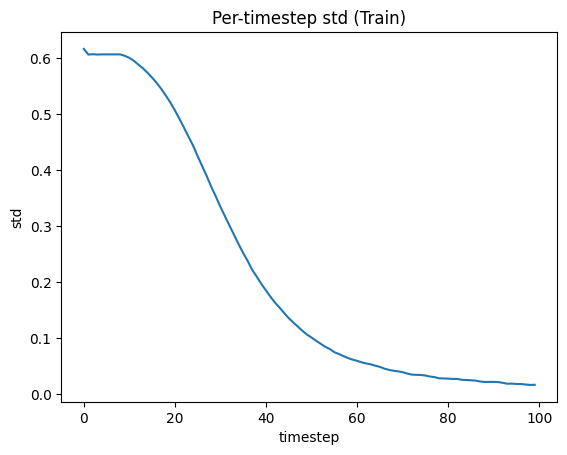

Dead timesteps (std≈0): 0


In [12]:
# 4. timesteps check
time_mean = X_train.mean(axis=(0,2))  # each time step mean
time_std  = X_train.std(axis=(0,2))   # each time step std
plt.plot(time_std)
plt.title("Per-timestep std (Train)")
plt.xlabel("timestep")
plt.ylabel("std")
plt.show()
print("Dead timesteps (std≈0):", (time_std < 1e-6).sum())

True Length Count：
  min: 8
  max: 100
  mean: 26.237287097169464
  median: 25.0


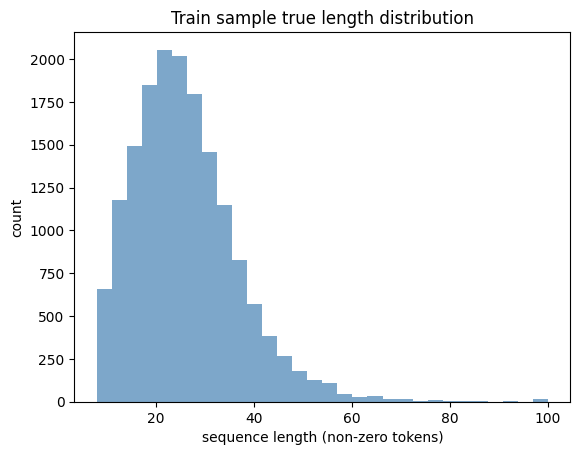

In [13]:
# 5. true length check
def get_true_lengths(X, tol=1e-8):
    norms = np.linalg.norm(X, axis=2)
    nonzero_mask = norms > tol
    lengths = nonzero_mask.sum(axis=1)
    return lengths

train_lengths = get_true_lengths(X_train)

print("True Length Count：")
print("  min:", train_lengths.min())
print("  max:", train_lengths.max())
print("  mean:", train_lengths.mean())
print("  median:", np.median(train_lengths))

plt.hist(train_lengths, bins=30, alpha=0.7, color="steelblue")
plt.title("Train sample true length distribution")
plt.xlabel("sequence length (non-zero tokens)")
plt.ylabel("count")
plt.show()

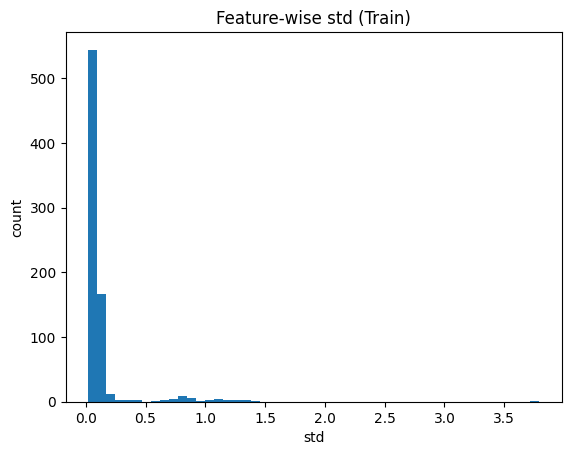

Dead features (std≈0): 0


In [14]:
# 6. feature dimension check
feat_std = X_train.std(axis=(0,1))  # (768,)
plt.hist(feat_std, bins=50)
plt.title("Feature-wise std (Train)")
plt.xlabel("std")
plt.ylabel("count")
plt.show()
print("Dead features (std≈0):", (feat_std < 1e-6).sum())

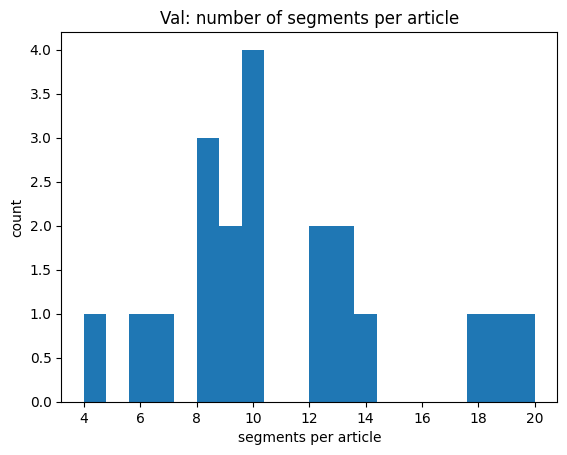

In [15]:
# 7. validation id → sequences in ids count
unique_ids, counts = np.unique(val_ids, return_counts=True)
plt.hist(counts, bins=20)
plt.title("Val: number of segments per article")
plt.xlabel("segments per article")
plt.ylabel("count")
plt.show()

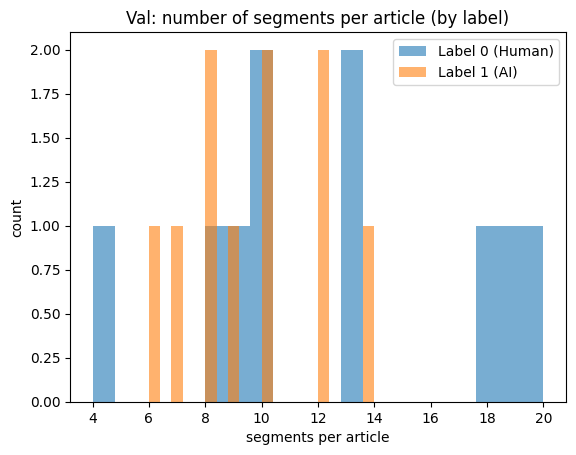

In [16]:
# 7. extension
doc_labels = {}
doc_counts = {}

for uid in np.unique(val_ids):
    mask = (val_ids == uid)
    doc_counts[uid] = np.sum(mask)  
    doc_labels[uid] = y_val[mask][0]  

counts = np.array(list(doc_counts.values()))
labels = np.array(list(doc_labels.values()))

counts_0 = counts[labels == 0]
counts_1 = counts[labels == 1]

plt.hist(counts_0, bins=20, alpha=0.6, label="Label 0 (Human)")
plt.hist(counts_1, bins=20, alpha=0.6, label="Label 1 (AI)")
plt.title("Val: number of segments per article (by label)")
plt.xlabel("segments per article")
plt.ylabel("count")
plt.legend()
plt.show()

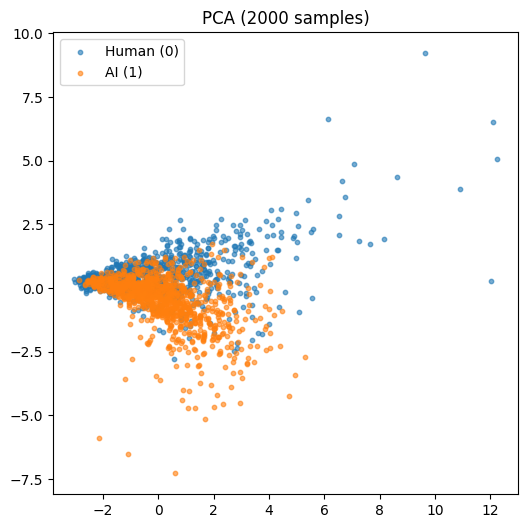

In [17]:
# 8. PCA
from sklearn.decomposition import PCA

X_pool = X_train.mean(axis=1)   # mean pooling
y = y_train

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_pool[:2000])
y_sub = y[:2000]

plt.figure(figsize=(6,6))
plt.scatter(X_pca[y_sub==0,0], X_pca[y_sub==0,1], s=10, alpha=0.6, label="Human (0)")
plt.scatter(X_pca[y_sub==1,0], X_pca[y_sub==1,1], s=10, alpha=0.6, label="AI (1)")
plt.legend()
plt.title("PCA (2000 samples)")
plt.show()

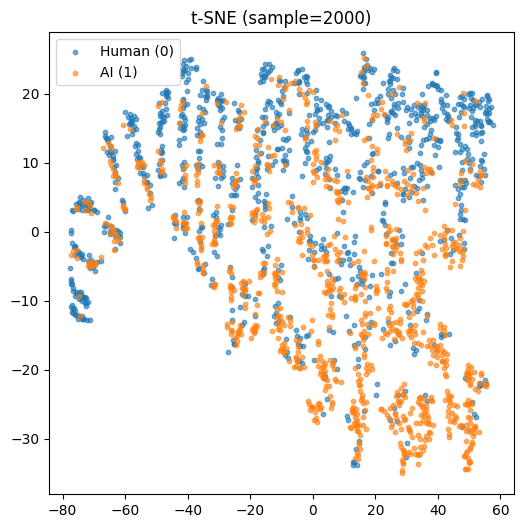

In [19]:
# 9. tsen
from sklearn.manifold import TSNE

idx = np.random.choice(len(X_pool), 2000, replace=False)
X_sample = X_pool[idx]
y_sample = y_train[idx]

X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_sample)

plt.figure(figsize=(6,6))
plt.scatter(X_tsne[y_sample==0,0], X_tsne[y_sample==0,1], s=10, alpha=0.6, label="Human (0)")
plt.scatter(X_tsne[y_sample==1,0], X_tsne[y_sample==1,1], s=10, alpha=0.6, label="AI (1)")
plt.legend()
plt.title("t-SNE (sample=2000)")
plt.show()

In [20]:
# 9. cosine similarity
from numpy.linalg import norm

# pool (N,100,768) → (N,768)
X_pool = X_train.mean(axis=1)

X_ai = X_pool[y_train==1]
X_hm = X_pool[y_train==0]

ai_mean = X_ai.mean(axis=0)
hm_mean = X_hm.mean(axis=0)

euclid_dist = norm(ai_mean - hm_mean)
cos_sim = np.dot(ai_mean, hm_mean) / (norm(ai_mean)*norm(hm_mean))

print("Euc Distance:", euclid_dist)
print("Cosine Similarity:", cos_sim)

Euc Distance: 0.9932866
Cosine Similarity: 0.9775076


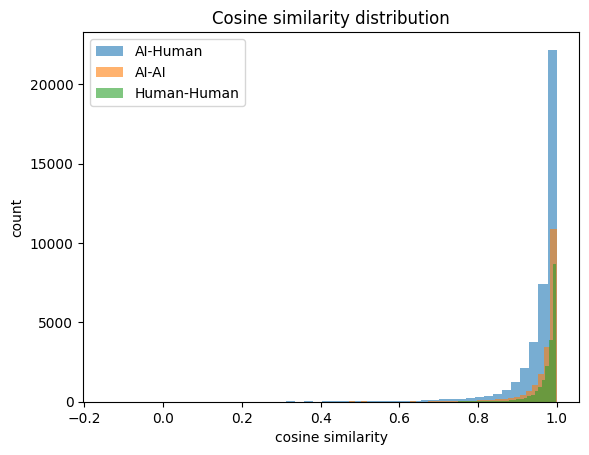

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

ai_sample = X_ai[:200]
hm_sample = X_hm[:200]

sim_ai_ai = cosine_similarity(ai_sample, ai_sample)
sim_hm_hm = cosine_similarity(hm_sample, hm_sample)
sim_ai_hm = cosine_similarity(ai_sample, hm_sample)

def upper_tri_flat(mat):
    return mat[np.triu_indices_from(mat, k=1)]

vals_ai_ai = upper_tri_flat(sim_ai_ai)
vals_hm_hm = upper_tri_flat(sim_hm_hm)
vals_ai_hm = sim_ai_hm.ravel()

plt.hist(vals_ai_hm, bins=50, alpha=0.6, label="AI-Human")
plt.hist(vals_ai_ai, bins=50, alpha=0.6, label="AI-AI")
plt.hist(vals_hm_hm, bins=50, alpha=0.6, label="Human-Human")

plt.legend()
plt.title("Cosine similarity distribution")
plt.xlabel("cosine similarity")
plt.ylabel("count")
plt.show()

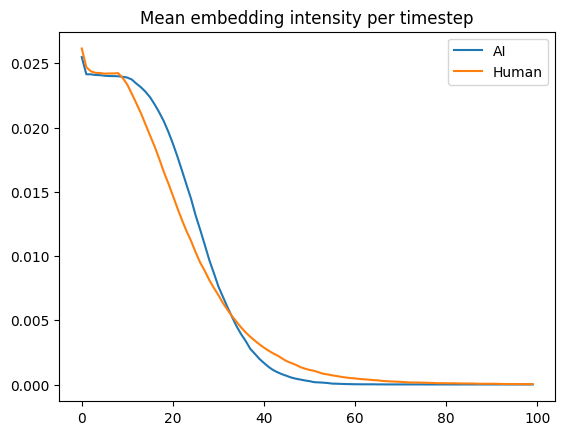

In [22]:
ai_time_mean = X_train[y_train==1].mean(axis=(0,2))  # (100,)
hm_time_mean = X_train[y_train==0].mean(axis=(0,2))  # (100,)

plt.plot(ai_time_mean, label="AI")
plt.plot(hm_time_mean, label="Human")
plt.legend(); plt.title("Mean embedding intensity per timestep")
plt.show()

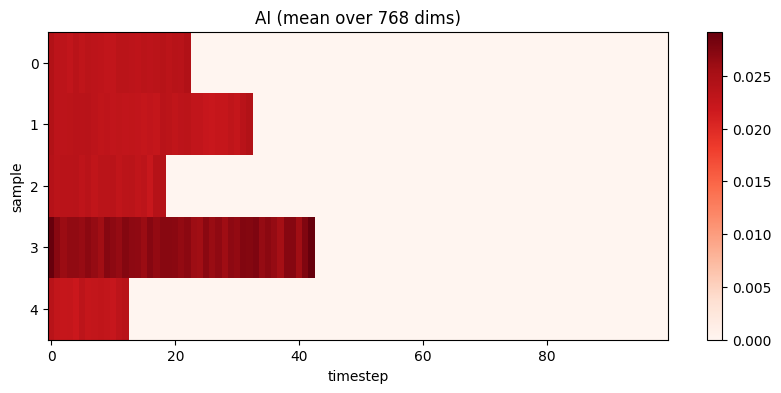

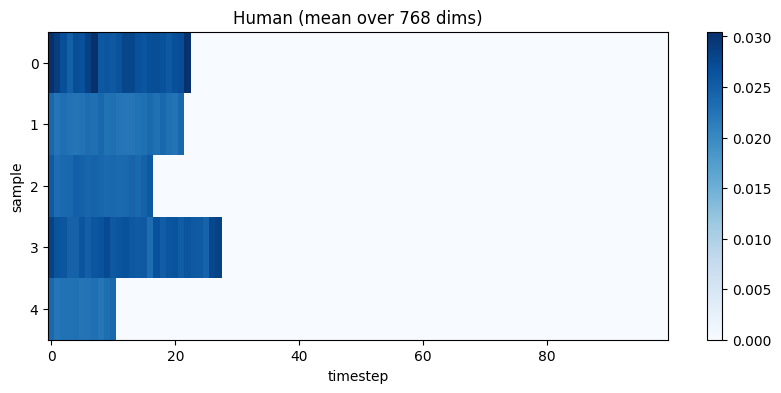

In [23]:
X_ai_time = X_train[y_train==1][:5].mean(axis=2)   # (5,100)
X_hm_time = X_train[y_train==0][:5].mean(axis=2)   # (5,100)

plt.figure(figsize=(10,4))
plt.imshow(X_ai_time, aspect="auto", cmap="Reds")
plt.colorbar(); plt.title("AI (mean over 768 dims)")
plt.xlabel("timestep"); plt.ylabel("sample")
plt.show()

plt.figure(figsize=(10,4))
plt.imshow(X_hm_time, aspect="auto", cmap="Blues")
plt.colorbar(); plt.title("Human (mean over 768 dims)")
plt.xlabel("timestep"); plt.ylabel("sample")
plt.show()